In [135]:
import pandas as pd
import numpy as np
import nltk as nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
nltk.download('wordnet')
import regex as re
import matplotlib.pyplot as plt
import transformers
import torch
from sklearn.metrics import accuracy_score, log_loss
import spacy
from spacy.cli import download
download('en_core_web_sm')

[nltk_data] Downloading package stopwords to /Users/ahmad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ahmad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ahmad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 36.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


<h3 style="color:#fdd3a9">Stage 1 -  Loading Datasets</h3>

In [136]:
# Loading Datasets from the CSV's using pandas built function
# Data is collected from two different sources for Training, Validation and Testing Purposes

FakeNewsNet_Politifact_True = pd.read_csv("Datasets/FakeNewsNet/politifact_real.csv")
FakeNewsNet_Politifact_Fake = pd.read_csv("Datasets/FakeNewsNet/politifact_fake.csv")
FakeNewsNet_Gossipcorp_True = pd.read_csv("Datasets/FakeNewsNet/gossipcop_real.csv")
FakeNewsNet_Gossipcorp_Fake = pd.read_csv("Datasets/FakeNewsNet/gossipcop_fake.csv")
ISOT_Dataset_True = pd.read_csv("Datasets/ISOT-dataset/True.csv")
ISOT_Dataset_Fake= pd.read_csv("Datasets/ISOT-dataset/Fake.csv")

<p style="color:lightblue"><b style="color:lightgreen">Dataset  1 - FakeNewsNet Dataset: </b> This dataset includes fact checked articles from Poltifact and GossipCorp. The dataset includes Newsaticle and the relevant social media content from the twitter. There are four CSV files (politifact_fake, politifact_real, gossipcop_fake, gossipcop_real). This intuition behind having a twitter based dataset is to get the human emotion and writing style for training the models</p>

https://github.com/KaiDMML/FakeNewsNet

In [137]:
FakeNewsNet_Politifact_True

,id,news_url,title,tweet_ids
0,politifact14984,http://www.nfib-sbet.org/,National Federation of Independent Business,967132259869487105\t967164368768196609\t967215...
1,politifact12944,http://www.cq.com/doc/newsmakertranscripts-494...,comments in Fayetteville NC,942953459\t8980098198\t16253717352\t1668513250...
2,politifact333,https://web.archive.org/web/20080204072132/htt...,"Romney makes pitch, hoping to close deal : Ele...",NaN
3,politifact4358,https://web.archive.org/web/20110811143753/htt...,Democratic Leaders Say House Democrats Are Uni...,NaN
4,politifact779,https://web.archive.org/web/20070820164107/htt...,"Budget of the United States Government, FY 2008",89804710374154240\t91270460595109888\t96039619...
...,...,...,...,...
619,politifact14731,https://www.flake.senate.gov/public/index.cfm/...,Flake: “Religious tests should have no place i...,NaN
620,politifact329,https://web.archive.org/web/20080131000131/htt...,Change We Can Believe In,634287923135909888\t946743411100536832\t946816...
621,politifact1576,http://www.youtube.com/watch?v=4O8CxZ1OD58,deputy director of national health statistics ...,NaN
622,politifact4720,http://www.youtube.com/watch?v=EhyMplwY6HY,Romneys ProLife Conversion Myth or Reality Jun...,188871706637647874


In [138]:
FakeNewsNet_Gossipcorp_True

,id,news_url,title,tweet_ids
0,gossipcop-882573,https://www.brides.com/story/teen-mom-jenelle-...,Teen Mom Star Jenelle Evans' Wedding Dress Is ...,912371411146149888\t912371528343408641\t912372...
1,gossipcop-875924,https://www.dailymail.co.uk/tvshowbiz/article-...,Kylie Jenner refusing to discuss Tyga on Life ...,901989917546426369\t901989992074969089\t901990...
2,gossipcop-894416,https://en.wikipedia.org/wiki/Quinn_Perkins,Quinn Perkins,931263637246881792\t931265332022579201\t931265...
3,gossipcop-857248,https://www.refinery29.com/en-us/2018/03/19192...,I Tried Kim Kardashian's Butt Workout & Am For...,868114761723936769\t868122567910936576\t868128...
4,gossipcop-884684,https://www.cnn.com/2017/10/04/entertainment/c...,Celine Dion donates concert proceeds to Vegas ...,915528047004209152\t915529285171122176\t915530...
...,...,...,...,...
16812,gossipcop-891749,https://omgcheckitout.com/2017-hollywood-film-...,2017 Hollywood Film Awards: The Complete List ...,927385466357260288\t927386601034010625\t927387...
16813,gossipcop-941486,https://pagesix.com/2018/06/04/jada-pinkett-sm...,Jada Pinkett Smith explains why son Jaden move...,1004044947006386178\t1004045964401889285\t1004...
16814,gossipcop-953143,https://www.etonline.com/tinsley-mortimer-reac...,Tinsley Mortimer Reacts to Luann de Lesseps' R...,1019924845889572864\t1019925702676709377\t1019...
16815,gossipcop-954366,https://www.healthbreakingnews.net/2018/07/pri...,Prince Harry Carries on Princess Diana’s Legac...,1021766291139584000\t1021772054599802880\t1021...


In [139]:
FakeNewsNet_Politifact_Fake

,id,news_url,title,tweet_ids
0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...
1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...
2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...
3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...
4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...
...,...,...,...,...
427,politifact14944,http://thehill.com/homenews/senate/369928-who-...,Who is affected by the government shutdown?,954602090462146560\t954602093171609600\t954650...
428,politifact14071,https://web.archive.org/web/20170322070001/htt...,Lindsey Graham Threatens To Convert To Democra...,740351669834244096\t740391312277573632\t740474...
429,politifact13577,http://archive.is/DQqCx,ELECTORAL COLLEGE ELECTOR COMMITS SUICIDE TO A...,810939651900907520\t814738996706164737\t814917...
430,politifact13560,politicono.com/palin-calls-boycott-mall-americ...,Sarah Palin Calls To Boycott Mall Of America B...,805216591424212993\t805222830023540736\t805223...


In [140]:
FakeNewsNet_Gossipcorp_Fake

,id,news_url,title,tweet_ids
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,284329075902926848\t284332744559968256\t284335...
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,992895508267130880\t992897935418503169\t992899...
2,gossipcop-941805037,variety.com/2017/biz/news/tax-march-donald-tru...,Celebrities Join Tax March in Protest of Donal...,853359353532829696\t853359576543920128\t853359...
3,gossipcop-2547891536,www.dailymail.co.uk/femail/article-3499192/Do-...,Cindy Crawford's daughter Kaia Gerber wears a ...,988821905196158981\t988824206556172288\t988825...
4,gossipcop-5476631226,variety.com/2018/film/news/list-2018-oscar-nom...,Full List of 2018 Oscar Nominations – Variety,955792793632432131\t955795063925301249\t955798...
...,...,...,...,...
5318,gossipcop-6702260693,www.huffingtonpost.com/2012/09/11/september-11...,September 11: Celebrities Remember 9/11 (TWEETS),245643768638894080
5319,gossipcop-6051845337,www.dailymail.co.uk/news/article-4915674/NASCA...,NASCAR owners threaten to fire drivers who pro...,912048333413330944\t912048571482087424\t912049...
5320,gossipcop-2435526162,www.telegraph.co.uk/men/the-filter/7-signs-dav...,The 7 signs that David Beckham is definitely h...,897794716447539200\t897804460830928896\t897842...
5321,gossipcop-4576152851,www.vanityfair.com/style/2016/09/ryan-gosling-...,Ryan Gosling and Eva Mendes Did Not Get Marrie...,778678901572710400\t778681718714740736\t778683...


<p style="color:lightblue">All four files discussed above will be combined together, therefore, there is need to add label based on the type of data presented in the files</p>

In [141]:
# Adding label "true" to both FakeNewsNet_Politifact_True and FakeNewsNet_Gossipcorp_True

FakeNewsNet_Politifact_True["label"] = str("true")
FakeNewsNet_Gossipcorp_True["label"] = str("true")

In [142]:
# Adding label "fake" to both FakeNewsNet_Politifact_True and FakeNewsNet_Gossipcorp_True
FakeNewsNet_Gossipcorp_Fake["label"] = str("fake")
FakeNewsNet_Politifact_Fake["label"] = str("fake")


<p style="color:lightblue">Now Labels are added to each datasets, therefore, these will be combined together for preprocessing and cleaning.</p>

In [143]:
# Concatenating the FakeNewsNet_Politifact_True, FakeNewsNet_Gossipcorp_True, FakeNewsNet_Politifact_Fake and FakeNewsNet_Gossipcorp_Fake
FakeNewsNet_Combined = pd.concat([FakeNewsNet_Politifact_True, FakeNewsNet_Gossipcorp_True, FakeNewsNet_Politifact_Fake, FakeNewsNet_Gossipcorp_Fake])

In [144]:
FakeNewsNet_Combined

,id,news_url,title,tweet_ids,label
0,politifact14984,http://www.nfib-sbet.org/,National Federation of Independent Business,967132259869487105\t967164368768196609\t967215...,true
1,politifact12944,http://www.cq.com/doc/newsmakertranscripts-494...,comments in Fayetteville NC,942953459\t8980098198\t16253717352\t1668513250...,true
2,politifact333,https://web.archive.org/web/20080204072132/htt...,"Romney makes pitch, hoping to close deal : Ele...",NaN,true
3,politifact4358,https://web.archive.org/web/20110811143753/htt...,Democratic Leaders Say House Democrats Are Uni...,NaN,true
4,politifact779,https://web.archive.org/web/20070820164107/htt...,"Budget of the United States Government, FY 2008",89804710374154240\t91270460595109888\t96039619...,true
...,...,...,...,...,...
5318,gossipcop-6702260693,www.huffingtonpost.com/2012/09/11/september-11...,September 11: Celebrities Remember 9/11 (TWEETS),245643768638894080,fake
5319,gossipcop-6051845337,www.dailymail.co.uk/news/article-4915674/NASCA...,NASCAR owners threaten to fire drivers who pro...,912048333413330944\t912048571482087424\t912049...,fake
5320,gossipcop-2435526162,www.telegraph.co.uk/men/the-filter/7-signs-dav...,The 7 signs that David Beckham is definitely h...,897794716447539200\t897804460830928896\t897842...,fake
5321,gossipcop-4576152851,www.vanityfair.com/style/2016/09/ryan-gosling-...,Ryan Gosling and Eva Mendes Did Not Get Marrie...,778678901572710400\t778681718714740736\t778683...,fake


<p style="color:#a7aef9"> We can Validate that the combined record is exactly matching with the individual dataset
</p>

<ul style="color:#a7aef9">
    <li> FakeNewsNet_Politifact_True  : 624 rows × 5 columns</li>
    <li> FakeNewsNet_Politifact_Fake  : 432 rows × 5 columns</li>
    <li> FakeNewsNet_Gossipcorp_True  : 16,817 rows × 5 columns</li>
    <li> FakeNewsNet_Gossipcorp_Fake  : 5,323 rows × 5 columns</li>
    <li style="color:#fdd3a9"> FakeNewsNet_Combined  : 23,196 rows × 5 columns</li>
</ul>

<p style="color:#b9d6e9"><b style="color:lightgreen">Dataset  2 - ISOT Fake Dataset : </b> This dataset has two subsets (1) pertains for the true news and (2) contains fake news. True news was  obtained using the crawlers over the articles available from reuters.com and False news taken from unreliable websites tagged as fake by Politifact.com. The columns and its nature is as follow: </p>

<ul style="color:#a7aef9">
<li>Index : Showing the number of fake news in a dataset</li>
<li>Title : Title of the news posted on Reuters</li>
<li>Text : Text for the News related to the title</li>
<li>Subject : Type of news posted such as political, world, fashion etc</li>
<li>Date : Date on which the news article was published</li>
</ul>



<p style="color:#b9d6e9"> This Datasets is more inclined towards actual news instead short text tweets posted by the users.Since, both datasets will be combined, therefore, there is need to tag the news either as "Fake" and "True"</p>

In [145]:
ISOT_Dataset_True

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [146]:
ISOT_Dataset_Fake

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


<p style="color:#b9d6e9"> Adding label fake and true to the datasets and combining both datasets together</p>

In [147]:
#Adding label to the datasets for better identification
ISOT_Dataset_True["label"] = str("true")
ISOT_Dataset_Fake["label"] = str("fake")

In [148]:
# Combing both datasets together to before preprocessing and cleaning both datasets [ISOT and FakeNewsNet]
ISOT_Dataset_Combined = pd.concat([ISOT_Dataset_True, ISOT_Dataset_Fake])


In [149]:
ISOT_Dataset_Combined

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",true
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",true
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",true
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",true
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",true
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",fake
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",fake
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",fake
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",fake


<p style="color:#a7aef9"> We can Validate that the combined record is exactly matching with the individual dataset (i.e. ISOT_Datatset_True and ISOT_Dataset_Fake)
</p>

<ul style="color:#a7aef9">
    <li> ISOT_Datatset_True  : 21,417 rows × 4 columns</li>
    <li> ISOT_Datatset_Fake  : 23,481 rows × 4 columns</li>
    <li style="color:#fdd3a9"> ISOT_Dataset_Combined  : 44,898 rows × 5 columns</li>
</ul>

<h3 style="color:#fdd3a9">Stage 2 -  Data Cleaning and Preprocessing</h3>

<p style="color:#45b6fe"><b style="color:lightgreen">1. Combining Datasets :</b> First of All, we have too combine both datasets together before performing any preprocessing. The Columns in both Datasets and its representation are as follows:</p>

<ul style="color:#45b6fe">
    <li> Title</li> 
    <li> Text</li> 
    <li> Label</li>
</ul>

<p style="color:#45b6fe">There is no Text field in FakeNewsNet, therefore, both Tile and Text will be combined once both FakeNewsNet and ISOT datasets merged together. Title and Text are also combined together as both are interrelated and it is not available in FakeNewsNet dataset.</p>

In [150]:
#Concatenating the FakeNewsNet_Combined and ISOT_Dataset_Combined before preprocessing and cleaning both datasets. 
#Columns combined into a single dataset are title, text and label.
FakeNewsNet_ISOT_Combined = pd.concat([FakeNewsNet_Combined[['title', 'label']], ISOT_Dataset_Combined[['title','label','text']]], ignore_index=True)



In [151]:
#Since, Text is only included in the ISOT dataset, therefore, it is kept as blank. 
FakeNewsNet_ISOT_Combined['text'] = FakeNewsNet_ISOT_Combined['text'].fillna("")

#NAN has been eliminated by keeping it as Blank
FakeNewsNet_ISOT_Combined

,title,label,text
0,National Federation of Independent Business,true,
1,comments in Fayetteville NC,true,
2,"Romney makes pitch, hoping to close deal : Ele...",true,
3,Democratic Leaders Say House Democrats Are Uni...,true,
4,"Budget of the United States Government, FY 2008",true,
...,...,...,...
68089,McPain: John McCain Furious That Iran Treated ...,fake,21st Century Wire says As 21WIRE reported earl...
68090,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,fake,21st Century Wire says It s a familiar theme. ...
68091,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,fake,Patrick Henningsen 21st Century WireRemember ...
68092,How to Blow $700 Million: Al Jazeera America F...,fake,21st Century Wire says Al Jazeera America will...


In [152]:
#Merging both columns title and text columns with each other for the training purposes because both are interlinked with each other.
FakeNewsNet_ISOT_Combined['title_text'] = FakeNewsNet_ISOT_Combined['title'] + ' ' + FakeNewsNet_ISOT_Combined['text']

#Since, we have combined title and text, therefore, we can opt to drop these individual columns from datasets as these are not required and it will also make our dataset smaller.
FakeNewsNet_ISOT_Combined = FakeNewsNet_ISOT_Combined.drop(['title', 'text'], axis=1)

In [153]:
FakeNewsNet_ISOT_Combined

,label,title_text
0,true,National Federation of Independent Business
1,true,comments in Fayetteville NC
2,true,"Romney makes pitch, hoping to close deal : Ele..."
3,true,Democratic Leaders Say House Democrats Are Uni...
4,true,"Budget of the United States Government, FY 2008"
...,...,...
68089,fake,McPain: John McCain Furious That Iran Treated ...
68090,fake,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...
68091,fake,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...
68092,fake,How to Blow $700 Million: Al Jazeera America F...


In [182]:
result = FakeNewsNet_ISOT_Combined[FakeNewsNet_ISOT_Combined['title_text'].str.contains('trump', case=False) & 
FakeNewsNet_ISOT_Combined['title_text'].str.contains('2017', case=False) & 
FakeNewsNet_ISOT_Combined['title_text'].str.contains('son', case=False) & 
FakeNewsNet_ISOT_Combined['title_text'].str.contains('pain', case=False)]

# result['title_text'].head(32)

print_dataset(result,32,"title_text")

1 => trump supporter object prince harry recent engagement terrible reason tweet great britain buckingham palace announced yesterday prince harry youngest son diana princess wale gotten engaged royal engagement always big news united kingdom one also hit home united state harry now-fiance american actress meghan markle best known role rachel zane legal drama series suit well special agent amy jessup sci-fi thriller fringethe british royal family longer hold anywhere near much clout essentially relegated mere tabloid fodder many expressing happiness online one windsor beloved member quite trump supporter expressed dissatisfaction prince choice see markle biracial father caucasian mother african-american mind many deplorables bad thingit completely irrelevant prince philip duke edinburgh husband reigning queen elizabeth ii half-greek pretty much white however news broke prince harry engagement markle white supremacist across united state around globe took twitter twisted mind disturbing 

In [155]:
FakeNewsNet_ISOT_Combined.isnull().sum()

label         0
title_text    0
dtype: int64

In [156]:
FakeNewsNet_ISOT_Combined.count()

label         68094
title_text    68094
dtype: int64

<p style="color:#45b6fe">There is no null value or missing record in the final dataset. However, unwanted columns are dropped for clarity and to make the dataset smaller.</p>

<p style="color:#45b6fe"><b style="color:lightgreen">2. Checking Duplicate Records :</b> This step involve checking the duplicate records to ensure the followings:/p>

<ul style="color:#45b6fe">
    <li> Since, two datasets are combined with each other so there are chances of having a duplicate records.</li> 
    <li> There are also chances of having duplicated records in same dataset.</li> 
</ul>

In [157]:
#Identifying the number of the duplicates records from the data frame
Duplicate_Records = FakeNewsNet_ISOT_Combined.duplicated(subset=['title_text'], keep='first')
print("Duplicate record count:")
print(Duplicate_Records.groupby(Duplicate_Records).count())

Duplicate record count:
False    60829
True      7265
dtype: int64


<p style="color:#45b6fe">There are 7,265 records which are duplicated and needs to be removed from the dataset and 60,829 records are unique.</p>
<p style="color:#fdd3a9"> Original Dataset [68,094 rows] <b>-</b> Duplicate Records [7,265 rows] <b>=</b> Cleaned Dataset [60,829 rows] </p>

In [158]:
#Removing the duplicate records from the data frame.
FakeNewsNet_ISOT_Combined = FakeNewsNet_ISOT_Combined[~Duplicate_Records]
FakeNewsNet_ISOT_Combined

,label,title_text
0,true,National Federation of Independent Business
1,true,comments in Fayetteville NC
2,true,"Romney makes pitch, hoping to close deal : Ele..."
3,true,Democratic Leaders Say House Democrats Are Uni...
4,true,"Budget of the United States Government, FY 2008"
...,...,...
67311,fake,The White House and The Theatrics of ‘Gun Cont...
67312,fake,Activists or Terrorists? How Media Controls an...
67313,fake,"BOILER ROOM – No Surrender, No Retreat, Heads ..."
67314,fake,Federal Showdown Looms in Oregon After BLM Abu...


<p style="color:#45b6fe"><b style="color:lightgreen">2. Converting text to String :</b> Currently datatype of text_title column is object. This should be converted into string for further text related cleaning activities.</p>

In [159]:
#Dataframe is copied to avoid the issue of "SettingWithCopyWarning"
FakeNewsNet_ISOT_Combined = FakeNewsNet_ISOT_Combined.copy()
#text_title is changes to string from object
FakeNewsNet_ISOT_Combined['title_text'] = FakeNewsNet_ISOT_Combined['title_text'].astype("string")

In [160]:
FakeNewsNet_ISOT_Combined.dtypes

label                 object
title_text    string[python]
dtype: object

In [161]:
#Function to Print the dataset rows as text to observe the data
from typing import Union

def print_dataset(ds: Union[pd.DataFrame, pd.Series], counts: int, txt: str, tail: bool = False):
    j = 0
    if tail:
        data_subset = ds.tail(counts)
    else:
        data_subset = ds.head(counts)
    
    for i in data_subset[txt]:
        j += 1
        print(j, "=>", i)
        print()

In [162]:
#Getting first 10 records from the dataset
print_dataset(FakeNewsNet_ISOT_Combined,10,"title_text")

1 => National Federation of Independent Business 

2 => comments in Fayetteville NC 

3 => Romney makes pitch, hoping to close deal : Elections : The Rocky Mountain News 

4 => Democratic Leaders Say House Democrats Are United Against GOP Default Act 

5 => Budget of the United States Government, FY 2008 

6 => Donald Trump exaggerates when he says China has 'total control' over North Korea 

7 => 25th Amendment 

8 => 子供たちのコト。私のコト。 

9 => Briefing by White House Press Secretary Robert Gibbs, 9/10/09 

10 => A Solar Grand Plan: Scientific American 



In [163]:
#Getting last 10 records from the dataset
print_dataset(FakeNewsNet_ISOT_Combined,10,"title_text", tail=True)

1 => McPain: John McCain Furious That Iran Treated US Sailors Well 21st Century Wire says As 21WIRE reported earlier this week, the unlikely  mishap  of two US Naval vessels straying into Iranian waters   just hours before the President s State of the Union speech, followed by the usual parade of arch-neocons coming on TV in real time to declare the incident as  an act of aggression  by Iran against the United States   is no mere coincidence.24 hours after the incident, the Iranians returned all 11 US sailors, unharmed and in good spirits. The only remaining casualty from this event was an incident of a common condition in Washington known as  Pre-Traumatic Stress Disorder    suffered by a certain US Senator was mortified by the uneventful outcome which followed Daniel McAdams Ron Paul Institute  The two US Navy riverine command boats intercepted in Iranian territorial waters yesterday were sent on their way along with the crew of 10 US sailors after brief detention on Iranian soil.Acc

<p style="color:#45b6fe"><b style="color:lightgreen">3. Removing Unwanted text :</b> I have noted that there is unwanted text in the articles such as HTTP links (e.g. https://t.co/EmFjBw9uC1) to external sources like twitter or link to pics posted in social media e.g (pic.twitter.com/HDea8ujTPt). These should be removed to clean the text. </p>

In [164]:
def remove_unwanted_text(text):
    text = re.sub(r'http\S+', '', text) # remove http links
    text = re.sub(r"\bpic\.[^\s]+\b", "", text) # remove pics links
    text = re.sub(r"\bvid\.[^\s]+\b", "", text) # remove vids links
    text = re.sub(r"\b\d+(\.\d+)?\b", "", text) # remove numbers
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text) # remove @mentions - It is commonly used
    text = re.sub(r'\$\w*', '', text) # remove $ symbols
    text = re.sub(r'\#\w+', ' ', text) # remove hashtags - These are provided for twitter
    text = re.sub(r'_', ' ', text) # remove Underscore
    text = re.sub(r"\.+", "", text) # Removing full stops (. or .. or ..+)
    #Returning clean text
    return text


In [165]:
#Testing the unwanted text removal function
sentance = '''Good muffins``cost $3.88\nin '%%!the New York. #DraftReport #FinalProject Please buy me
... two 's of them having green apple colour stock. pic.twitter.com/HDea8ujTPt\n\n
Thanks. @UOL :) $127.2 _, https://london.ac.uk/ https://t.co/EmFjBw9uC1 {}''' 
sentance = remove_unwanted_text(sentance)
sentance

"Good muffins``cost \nin '%%!the New York     Please buy me\n two 's of them having green apple colour stock \n\n\nThanks   :)   ,   {}"

In [166]:
#Applying the unwanted text removal function to FakeNewsNet_ISOT_Combined
FakeNewsNet_ISOT_Combined['title_text'] = FakeNewsNet_ISOT_Combined['title_text'].apply(remove_unwanted_text)

<p style="color:#45b6fe"><b style="color:lightgreen">4. Removing Stopwords, Punctuations and Emojies :</b> It is quite common in the news articles to have stopwords, emojies or punctuations. Therefore, this step will involve removing all such things from the dataset to make it more focused and readable for the machine.</p>

In [167]:
emojis = set([
':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}', ':^)', 
':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D', '=-3', '=3', ':-))', 
":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P', 'x-p', 'xp', 'XP', ':-p', ':p', 
'=p', ':-b', ':b', '>:)', '>;)', '>:-)', '<3'':L', ':-/', '>:/', ':S', '>:[', 
':@', ':-(', ':[', ':-||', '=L', ':<', ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", 
":'(", ':\\', ':-c', ':c', ':{', '>:\\', ';('
])

In [168]:
#There are multiple libraries to perform this task such as Spacy, NLTK, SKlearn etc.
#I have used NLTK library because the results are almost close to the Spacy.
stop_words = (stopwords.words('english'))
punctuation = '''!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'s``–‘’0123456789''' #Used to remove punctuations.
def remove_stopwords_punch(text):
    # Word tokenization for the text parsed into the function
    word_tokens = word_tokenize(text)
    #Check for the stop_words and removing from the text
    filtered_stop_words = [w for w in word_tokens if not w.lower() in stop_words] #Checking for the punctuation and removing from the text
    filtered_punch_words = [w for w in filtered_stop_words if not w in punctuation] #Checking for the emojis and removing from the text
    filtered_emoj_words = [w for w in filtered_punch_words if not w in punctuation] #Joining the words again for input to dataframe column
    return(' '.join(filtered_emoj_words))

In [169]:
#Testing the stop word and punctuation removal function
remove_stopwords_punch(sentance)

'Good muffins cost New York Please buy two green apple colour stock Thanks'

In [170]:
#Applying the stop word and punctuation removal function to FakeNewsNet_ISOT_Combined
FakeNewsNet_ISOT_Combined['title_text'] = FakeNewsNet_ISOT_Combined['title_text'].apply(remove_stopwords_punch)

In [171]:
print_dataset(FakeNewsNet_ISOT_Combined,5,"title_text", tail=True)

1 => White House Theatrics Gun Control 21st Century Wire says world stage men women merely players exits entrances one man time plays many parts acts seven ages William Shakespeare Theatrics politics nothing new latest TV drama little over-the-top even entertainer-and-chief HIGH DRAMA Obama epic tears gun control rally TuesdayDuring President Barack Obama landmark New Year TV address gun control grew visibly emotional invoking Newtown bountiful tears arriving good measureWhile right-wing commentators incensed left-wing media pundits understandably blown away performance commented like performance media terms weird moment say leastOf course one would dare accuse President producing tears demand would impossible fake unless course extremely talented trained actor would believe President would received sort special coaching reserved professional TV film actorsThe thought simply preposterous right President surely actor Nonetheless high drama sure something seemed incredibly staged morning

<p style="color:#45b6fe"><b style="color:lightgreen">5. Making text to lower case :</b> The text is now converted to lower case to make it consistent and to reduce the dimensionality of the data because same word in different case could be considered as a different feature.</p>

In [172]:
# Making the text_title to lower case for consistency and to avoid the multiple occurences of the same words.
FakeNewsNet_ISOT_Combined['title_text'] = FakeNewsNet_ISOT_Combined['title_text'].str.lower()


<p style="color:#45b6fe"><b style="color:lightgreen">6. Stemming and Lemmatizing the text :</b> Text is lemmatized and stemmed to convert the text to its base, root or dictionary form.</p>

In [173]:
#Stemming and lemmatizing the title_text
# stemming = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

# Load the English language model
nlp = spacy.load('en_core_web_sm')

#Function to stem the sentences of the dataframe [title_text]
def lemmatize_data(text):
    # word_tokens = word_tokenize(text) # Getting word token for the dataframe text parsed into the function
    # stem_words = [stemming.stem(w) for w in word_tokens]
    # lem_words = [lemmatizer.lemmatize(w) for w in word_tokens]
    doc = nlp(text)  # Process the text with Spacy
    lem_words = [token.lemma_ for token in doc]  # Lemmatize each token in the processed text
    return(' '.join(lem_words))


In [174]:
#Testing the function to lemmatize and stem the wordings
sentance = "Programmers program with programming languages corpora"
stem_data(sentance)

'Programmers program with programming language corpus'

In [175]:
# Applying stemming and lemmatization  to FakeNewsNet_ISOT_Combined dataset.
FakeNewsNet_ISOT_Combined['title_text'] = FakeNewsNet_ISOT_Combined['title_text'].apply(stem_data)

<p style="color:#45b6fe"><b style="color:lightgreen">7. Rechecking the duplicate records :</b> It is always best practice to recheck the text after completing all preprocessing and cleaning tasks because there might be chances of having duplicate records again.</p>

In [176]:
#Final Check for the duplicate records
Duplicate_Records = FakeNewsNet_ISOT_Combined.duplicated(subset=['title_text'], keep='first')
print("Duplicate record count:")
print(Duplicate_Records.groupby(Duplicate_Records).count())

Duplicate record count:
False    60737
True        92
dtype: int64


<p style="color:#45b6fe"> There are few duplicate records that needed to be eliminated from the dataset.</p>

In [177]:
#Removing the duplicate records from the data frame.
FakeNewsNet_ISOT_Combined = FakeNewsNet_ISOT_Combined[~Duplicate_Records]
FakeNewsNet_ISOT_Combined

,label,title_text
0,true,national federation independent business
1,true,comment fayetteville nc
2,true,romney make pitch hoping close deal election r...
3,true,democratic leader say house democrat united go...
4,true,budget united state government fy
...,...,...
67311,fake,white house theatrics gun control 21st century...
67312,fake,activist terrorist medium control dictate narr...
67313,fake,boiler room surrender retreat head roll ep tun...
67314,fake,federal showdown loom oregon blm abuse local r...


In [178]:
record = FakeNewsNet_ISOT_Combined.iloc[45934]

print(record)

label                                                      fake
title_text    conservative cry meryl streep destroys trump g...
Name: 47710, dtype: object


<h3 style="color:#fdd3a9"> Dataframe Outlook</h3>

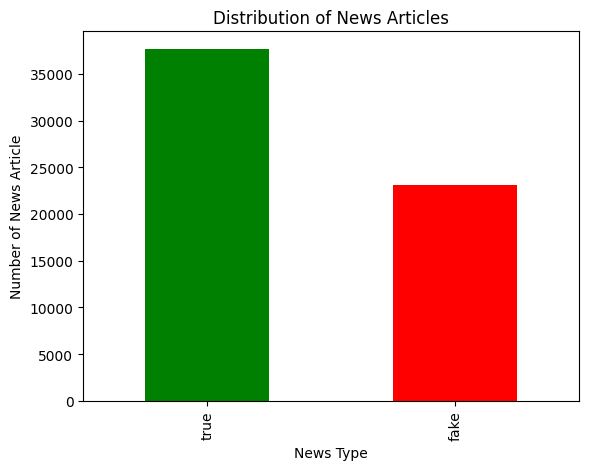

label
true    37655
fake    23082
Name: label, dtype: int64

In [179]:
#Checking the distribution of combined datasets based on news label
df_news = FakeNewsNet_ISOT_Combined.groupby('label')['label'].count()
df_news = df_news.sort_values(ascending = False) # Keeping the values in ascending order
bar_colors = list('grbkymc') #red, green, blue, black, etc.
df_news.plot(x = df_news[0], y= df_news[1], kind = 'bar', stacked=True, color=bar_colors)
# To add title and labels to the plot
plt.title('Distribution of News Articles') 
plt.ylabel('Number of News Article') 
plt.xlabel('News Type')
plt.show() 
#To show the distribution based on count
df_news

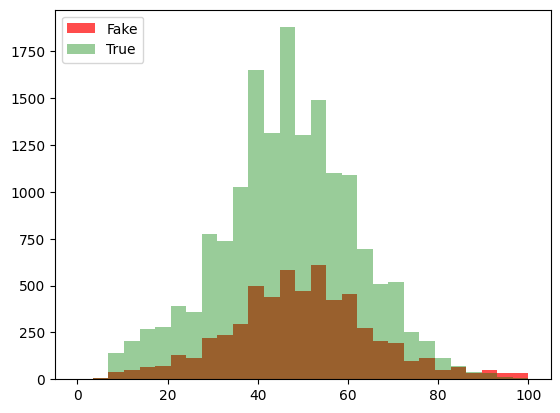

In [180]:
#Bucket size for the histogram
bins = np.linspace(0, 100, 30)
#To create a copy of the dataset because new column is added, it is good practice to do copy before preprocessing
df_news = FakeNewsNet_ISOT_Combined.copy()

df_news['text_length'] = df_news["title_text"].apply(lambda x: len(x) - x.count(" "))

plt.hist(df_news[df_news["label"]== "fake"]["text_length"], bins, alpha=0.7, label="Fake", color="red")
plt.hist(df_news[df_news["label"]== "true"]["text_length"], bins, alpha=0.4, label="True", color="green")
plt.legend(loc="upper left")
plt.show()


<h3 style="color:#fdd3a9"> Splitting and Exporting dataset</h3>

<p style="color:#45b6fe"><b style="color:lightgreen">1. Exporting Training data to CSV:</b> Training data is exported to CSV as these are used separately in Google Colab for the training reasons .</p>

In [181]:
#Pandas dataframe to CSV
FakeNewsNet_ISOT_Combined.to_csv('cleaned_data.csv', index=False)

<p style="color:#45b6fe"><b style="color:lightgreen">2. Split data into Training and Testing [Training: 80%, Testing:20%] :</b> Dataset is splitted into X_train, X_test, y_train, y_test using Sk-Learn library with the ratio 80% - Training and 20% Testing.</p>

<p>This splitting is performed in the Google Colab because of having limited resources in personal computer.</p>

<h3 style="color:#fdd3a9">Large Language Model (LLM) Training</h3>

<p style="color:#45b6fe"><b style="color:lightgreen">1. Zero shot classifier:</b> The first step will be using the zero shot classifier in which nothing will be provided for the context and only y parameters will be provided for classification label as "real and fake". Since, Skorch has access to all model available on Hugging Face, therefore, Bloomz is selected. This LLM is trained on 1 Billion parameters which could be considered small from today's standards.</p>

In [80]:
#This will eliminate the transformers logs while executing the code
transformers.logging.set_verbosity_warning()


In [81]:
#Defining the device to be used on the based on available resources
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [82]:
from skorch.llm import ZeroShotClassifier

In [83]:
clf = ZeroShotClassifier('bigscience/bloomz-1b7', device=device, use_caching=True)

In [84]:
%time clf.fit(X=None, y=['true', 'fake'])

CPU times: user 16.4 s, sys: 10.7 s, total: 27.1 s
Wall time: 25.4 s


ZeroShotClassifier(model_name='bigscience/bloomz-1b7')

In [93]:
X = X_train[:-100]
y = y_train[:-100]

In [94]:
%time y_proba = clf.predict_proba(X)

KeyboardInterrupt: 

In [ ]:

log_loss(y, y_proba)

1.5499419196825917

In [ ]:
y_pred = y_proba.argmax(1)
y_pred = np.array(['fake', 'true'])[y_pred]

In [ ]:
y_pred

array(['true', 'true', 'true', 'true', 'true', 'true', 'true', 'true',
       'true', 'true', 'true', 'true', 'true', 'true', 'true', 'true',
       'true', 'true', 'true', 'true', 'true', 'true', 'true', 'true',
       'true', 'true', 'true', 'true', 'true', 'true', 'true', 'true',
       'true', 'true', 'true', 'true', 'true', 'true', 'true', 'true',
       'true', 'true', 'true', 'true', 'true', 'true', 'true', 'true',
       'true', 'true', 'true', 'true', 'true', 'true', 'true', 'true',
       'true', 'true', 'true', 'true', 'true', 'true', 'true', 'true',
       'true', 'true', 'true', 'true', 'true', 'true', 'true', 'true',
       'true', 'true', 'true', 'true', 'true', 'true', 'true', 'true',
       'true', 'true', 'true', 'true', 'true', 'true', 'true', 'true',
       'true', 'true', 'true', 'true', 'true', 'true', 'true', 'true',
       'true', 'true', 'true', 'true'], dtype='<U4')

In [91]:
accuracy_score(y, y_pred)

0.65

In [92]:
from skorch.llm import FewShotClassifier
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

